In [1]:
from src.preprocessing.dataLoader_CelebA import get_partitioned_dataloaders, create_subset_loader
from src.ml.resNet50 import SiameseResNet
from src.ml.losses_utils import ContrastiveLoss
import torch
from src.ml.hyperparam_study import run_optuna_study

# 1. Load the data

In [2]:
IMAGE_DIR = "data/celeba/img_align_celeba"
LABEL_FILE = "data/celeba/identity_CelebA.txt"
PARTITION_FILE = "data/celeba/list_eval_partition.csv"
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_loader, val_loader, test_loader = get_partitioned_dataloaders(image_dir= IMAGE_DIR,
                                                               label_file= LABEL_FILE,
                                                               partition_file= PARTITION_FILE,
                                                               batch_size=BATCH_SIZE,
                                                               img_size=IMG_SIZE)


Label: tensor([0.])


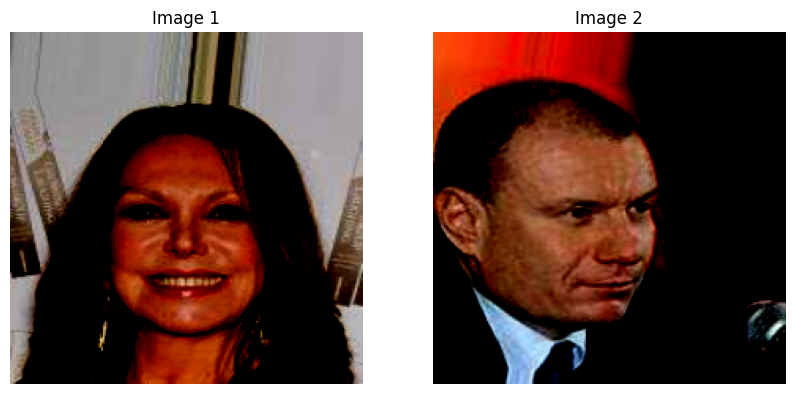

In [4]:
# Get one sample from the dataloader
dataiter = iter(test_loader)
img1, img2, label = next(dataiter)

# If you want to visualize the images, you can use matplotlib
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# For each image, we need to move the channels to the end and convert to numpy
# Assuming the images are in format (batch_size, channels, height, width)
img1_display = img1[0].permute(1, 2, 0).cpu().numpy()
img2_display = img2[0].permute(1, 2, 0).cpu().numpy()
print("\nLabel:", label[0])
# Display images
ax1.imshow(img1_display)
ax1.set_title('Image 1')
ax1.axis('off')

ax2.imshow(img2_display)
ax2.set_title('Image 2')
ax2.axis('off')

plt.show()

# Create the model

In [5]:
model = SiameseResNet()

# Find best Hyperparameters

In [6]:
train_loader_study = (create_subset_loader(train_loader,10000))
val_loader_study = (create_subset_loader(train_loader,2000))
study = run_optuna_study(train_loader_study, val_loader_study, n_trials=10, study_name="siamese_constrastive_HP_study")
best_params = study.best_params

[I 2025-05-25 18:14:31,850] Using an existing study with name 'siamese_constrastive_HP_study' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 - Iteration 0 - Training Loss: 31.4555
Epoch 0 - Iteration 10 - Training Loss: 22.2276
Epoch 0 - Iteration 20 - Training Loss: 24.1295
Epoch 0 - Iteration 30 - Training Loss: 16.9374
Epoch 0 - Iteration 40 - Training Loss: 20.4434
Epoch 0 - Iteration 50 - Training Loss: 19.8936
Epoch 0 - Iteration 60 - Training Loss: 15.2382
Epoch 0 - Iteration 70 - Training Loss: 21.5090
Epoch 0 - Iteration 80 - Training Loss: 21.4501
Epoch 0 - Iteration 90 - Training Loss: 21.2901
Epoch 0 - Iteration 100 - Training Loss: 20.0849
Epoch 0 - Iteration 110 - Training Loss: 18.6803
Epoch 0 - Iteration 120 - Training Loss: 16.1173
Epoch 0 - Iteration 130 - Training Loss: 15.9739
Epoch 0 - Iteration 140 - Training Loss: 14.0331
Epoch 0 - Iteration 150 - Training Loss: 17.9047
Epoch 0 - Iteration 160 - Training Loss: 16.3593
Epoch 0 - Iteration 170 - Training Loss: 15.6632
Epoch 0 - Iteration 180 - Training Loss: 17.0294
Epoch 0 - Iteration 190 - Training Loss: 16.4768
Epoch 0 - Iteration 200 - Train

KeyboardInterrupt: 

# Train Model

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

In [14]:
results = model.train_model_constructive(
        train_loader=create_subset_loader(train_loader,100),
        val_loader=create_subset_loader(val_loader,100),
        criterion=ContrastiveLoss(),
        optimizer=optimizer,
        num_epochs=5,
        device=DEVICE,
        patience=5,
        experiment_name='SiameseResNet',
        tuning_mode=False
    )

Epoch 0 - Training Loss: 0.2524, Validation Loss: 0.2670
Validation loss decreased (inf --> 0.267010). Saving model ...
Epoch 1 - Training Loss: 0.2681, Validation Loss: 0.2573
Validation loss decreased (0.267010 --> 0.257250). Saving model ...
Epoch 2 - Training Loss: 0.3028, Validation Loss: 0.2662
EarlyStopping counter: 1 out of 5
Epoch 3 - Training Loss: 0.2477, Validation Loss: 0.2714
EarlyStopping counter: 2 out of 5


KeyboardInterrupt: 

# Plot the results

In [ ]:
! mlflow ui --port 5000